# Predicting the prices of bulldozers using machine learning

This notebook consists of walking through a machine learning project with the goal of predicting sale prices of bulldozers.

I will use the following workflow:

[<img src='images/6-step-ml-framework.png'/>]()

## 1. Problem definition.

> How well can you predict the sale price of a bulldozer, given a set of attributes and a structured dataset of similarly attributed bulldozer sale prices previously sold?

## 2. Data.

I will be using the dataset provided by [Kaggle Bluebook for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

The data set is split into three `.csv` files:
* `Train.csv` is the training set, which contains data through the end of 2011.
* `Valid.csv` is the validation set, which contains data from January 1, 2012 - April 30, 2012.
* `Test.csv` is the test set, which contains data from May 1, 2012 - November 2012.

## 3. Evaluation.

> The evaluation metric for this [competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

The goal of this machine learning project is to build a machine learning model minimising RMSLE.

## 4. Features.

Kaggle provides a [data dictionary](https://www.kaggle.com/c/bluebook-for-bulldozers/data?) detailing every feature of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

In [2]:
# Import the training and validation datasets.
# The csv file is very large, and since pandas DataFrames aim to minimise the space they take up in RAM, we set 
# low_memory=False to let pandas know that we have enough RAM so it doesn't have to minimse the memory it needs.
df = pd.read_csv('data/TrainAndValid.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# There is hundreds of thousands of missing values in the dataset.
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

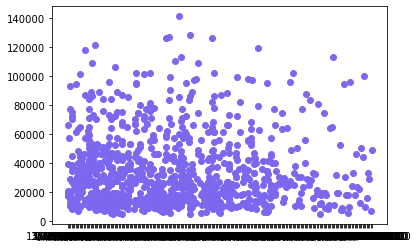

In [5]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000], c='mediumslateblue');

In [6]:
# Matplotlib isn't rendering 1000 dates well since this column has the type str.
df.saledate.dtype, type(df.saledate[0])

(dtype('O'), str)

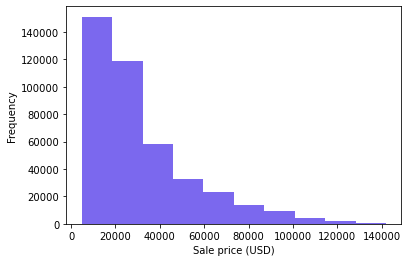

In [110]:
# Let's visualise this data another way.
ax = df.SalePrice.plot.hist(color='mediumslateblue')
ax.set_xlabel('Sale price (USD)');

Observations:
* The majority of bulldozer sale prices are below \$20,000 USD.
* The frequency of bulldozers sold decreases exponentially as sale price increases. 

### Time series data analysis.

When working with time series data, we want to utilise and enhance the time and date component as much as possible. We do that by telling pandas which columns has dates in it using the `parse_dates` parameter so that these values can be converted into a pandas `Timestamp` object, equivalent to Python `datetime` object.

In [8]:
# Import the data again utilising the parse_dates parameter.
df = pd.read_csv("data/TrainAndValid.csv", 
                 low_memory=False, 
                 parse_dates=['saledate'])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

Text(0, 0.5, 'Sale price (USD)')

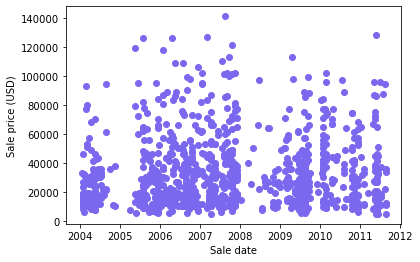

In [11]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000], c='mediumslateblue');
ax.set_xlabel('Sale date')
ax.set_ylabel('Sale price (USD)')

Observations:
* Financial crises in 2005 and 2008-2009 significantly plummeted the frequency of bulldozers sold.

In [12]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [14]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

When working with time series data, it's a good idea to sort the DataFrame by the date column.

In [15]:
# Sort the DataFrame by saledate
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [16]:
# Make a copy of original DataFrame so we manipulate the copy, not the original data.
df_tmp = df.copy()

### Feature engineering.

In [17]:
# Add datetime parameters for the saledate column
df_tmp['saleyear'] = df_tmp.saledate.dt.year
df_tmp['salemonth'] = df_tmp.saledate.dt.month
df_tmp['saleday'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [18]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [19]:
# Now we that we have enriched the DataFrame with datetime features, we can remove saledate.
df_tmp.drop('saledate', axis=1, inplace=True)

### Exploratory data analysis.

In [20]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

Perhaps do some more EDA later.

## 5. Modelling.

Model-driven exploratory data analysis.

In [21]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

model = RandomForestRegressor(n_jobs=-1, # Use as many cores as possible since the data set is very large.
                              random_state=42)

### Feature encoding.

We need to encode all non-numerical data features numerically before we can train a machine learning model. We will do this by converting the data to use pandas categories.

In [22]:
# Find columns with dtype of object
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [23]:
# Convert all object values into pandas.Categorical values.
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [24]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [25]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [26]:
# Under the hood, pandas categories converts objects into numerical form.
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

### Filling missing values.

In [27]:
df_tmp.isna().sum() / len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [28]:
# First save feature encoded DataFrame.
df_tmp.to_csv('data/train_tmp.csv', index=False)

# Import preprocessed data.
df_tmp = pd.read_csv('data/train_tmp.csv',
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


#### Filling missing numerical values.

In [29]:
# for label, content in df_tmp.items():
#     if pd.api.types.is_numeric_dtype(content):
#         print(label)

df_tmp._get_numeric_data().T

,0,1,2,3,4,5,6,7,8,9,...,412688,412689,412690,412691,412692,412693,412694,412695,412696,412697
SalesID,1646770.0,1821514.0,1505138.0,1671174.0,1329056.0,1301884.0,1379228.0,1645390.0,1493279.0,1449549.0,...,6283634.0,6282337.0,6311321.0,6306476.0,6281219.0,6302984.0,6324811.0,6313029.0,6266251.0,6283635.0
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363.0,1194089.0,1473654.0,1327630.0,1336053.0,1182999.0,1082797.0,1527216.0,1363756.0,1289412.0,...,1930870.0,1928688.0,1823846.0,1278794.0,1792049.0,1915521.0,1919104.0,1918416.0,509560.0,1869284.0
ModelID,8434.0,10150.0,4139.0,8591.0,4089.0,4123.0,7620.0,8202.0,2759.0,3356.0,...,4701.0,22072.0,17311.0,9114.0,13976.0,5266.0,19330.0,17244.0,3357.0,4701.0
datasource,132.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,...,149.0,149.0,149.0,149.0,149.0,149.0,149.0,149.0,149.0,149.0
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974.0,1980.0,1978.0,1980.0,1984.0,1976.0,1986.0,1970.0,1987.0,1966.0,...,1998.0,2005.0,2005.0,2004.0,2000.0,2001.0,2004.0,2004.0,1993.0,1000.0
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saleyear,1989.0,1989.0,1989.0,1989.0,1989.0,1989.0,1989.0,1989.0,1989.0,1989.0,...,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0
salemonth,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [30]:
# Check which numerical columns have missing values.

# for label, content in df_tmp.items():
#     if pd.api.types.is_numeric_dtype(content):
#         if pd.isna(content).sum():
#             print(label)

df_tmp._get_numeric_data().isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
saleyear                         0
salemonth                        0
saleday                          0
saleDayOfWeek                    0
saleDayOfYear                    0
dtype: int64

In [31]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            # Add a binary column indicating if the data was missing.
            df_tmp[label+'_is_missing'] = pd.isna(content)
            # Fill numeric columns with missing values with the median value (median is more robust than the mean).
            df_tmp[label] = content.fillna(content.median())

In [32]:
df_tmp._get_numeric_data().isna().sum()

SalesID                                0
SalePrice                              0
MachineID                              0
ModelID                                0
datasource                             0
auctioneerID                           0
YearMade                               0
MachineHoursCurrentMeter               0
saleyear                               0
salemonth                              0
saleday                                0
saleDayOfWeek                          0
saleDayOfYear                          0
auctioneerID_is_missing                0
MachineHoursCurrentMeter_is_missing    0
dtype: int64

In [33]:
df_tmp['auctioneerID_is_missing'].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [34]:
df_tmp['MachineHoursCurrentMeter_is_missing'].value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

#### Filling missing categorical values and encoding them numerically.

In [35]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [36]:
# Turn categorical columns into numbers and fill missing values:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column indicating if the data was missing.
        df_tmp[label+'_is_missing'] = pd.isna(content)
        # Convert non-numeric categorical columns' into numerical data by using the categorical code + 1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [37]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [38]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [39]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all the data is numeric and we have no missing values, we can continue with building machine learning models.

In [40]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [41]:
%%time
# Instantiate model.
model = RandomForestRegressor(n_jobs=-1)

# Create the feature matrix and labels vector.
X = df_tmp.drop('SalePrice', axis=1)
y = df_tmp['SalePrice']

# Fit the model.
model.fit(X, y)

CPU times: user 18min 15s, sys: 12 s, total: 18min 27s
Wall time: 6min 47s


RandomForestRegressor(n_jobs=-1)

In [42]:
# Score the model.
model.score(X, y)

0.9875468079970562

WAIT. The above metric is obviously not reliable because we scored it on the same data we trained it on. We are using `TrainAndValid.csv`, which consists of time series data, and in the specification of the data provided on Kaggle, we are told that the training set is the data through the end of 2011 and the validation set is the data from January 1, 2012 - April 30, 2012.

#### Splitting the data into training and validation sets.

In [43]:
df_tmp.saleyear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleyear, dtype: int64

In [44]:
# Training set
df_train = df_tmp[df_tmp['saleyear'] <= 2011]
df_valid = df_tmp[df_tmp['saleyear'] == 2012]

len(df_train), len(df_valid)

(401125, 11573)

In [45]:
# Creating the feature matrices and label vectors.
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_valid.drop('SalePrice', axis=1), df_valid['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building the evaluation metric function.

Scikit-Learn doesn't have an inbuilt root mean squared log error (RMSLE) function so I need to implement this function to use as the scoring parameter for the models.

In [46]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Calculates the root mean squared log error between predictions and actual labels.
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate the model on a few diffeent levels
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_valid, valid_preds),
        'Training RMSLE': rmsle(y_train, train_preds),
        'Valid RMSLE': rmsle(y_valid, valid_preds),
        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_valid, valid_preds)
    }
    return scores

### Testing the model on a subset of the data (for faster hyperparameter tuning).


In [47]:
# This takes far too long for experimentation
# %%time
# model = RandomForestRegressor(n_jobs=-1,
#                               random_state=42)

# model.fit(X_train, y_train)

In [48]:
len(X_train)

401125

In [49]:
%%time
# Change the max_samples parameter when initialising RandomForestRegressor to cut down model training time.
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)
model.fit(X_train, y_train)

CPU times: user 39.4 s, sys: 830 ms, total: 40.2 s
Wall time: 17.8 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [50]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV.

In [51]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters.
rf_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'auto'],
    'max_samples': [10000]
}

# Instantiate a RandomizedSearchCV model.
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model.
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.1min finished


CPU times: user 1min 16s, sys: 12 s, total: 1min 28s
Wall time: 3min 16s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [52]:
# Find the best model hyperparameters.
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 18,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [53]:
# Evaluate the RandomizedSearchCV model.
show_scores(rs_model)

{'Training MAE': 6116.268985145623,
 'Valid MAE': 7407.41382920978,
 'Training RMSLE': 0.2778297361264891,
 'Valid RMSLE': 0.30079218361701754,
 'Training R^2': 0.8339023980470646,
 'Valid R^2': 0.8220344426622025}

### Train a model with the best hyperparameters.

**Note:** These were found after 100 iterations of RandomizedSearchCV.

In [54]:
%%time

# Most ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # Setting random seed for reproducible results.

# Fit the ideal model.
ideal_model.fit(X_train, y_train)

CPU times: user 3min 28s, sys: 2.62 s, total: 3min 31s
Wall time: 1min 23s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [55]:
# Scores for the ideal model.
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [56]:
# Scores for rs_model (only trained on 10,000 samples)
show_scores(rs_model)

{'Training MAE': 6116.268985145623,
 'Valid MAE': 7407.41382920978,
 'Training RMSLE': 0.27782973612648904,
 'Valid RMSLE': 0.30079218361701754,
 'Training R^2': 0.8339023980470646,
 'Valid R^2': 0.8220344426622025}

### Using the model on the test data.

In [79]:
# Import the test data.
df_test = pd.read_csv('data/Test.csv',
                      low_memory=False,
                      parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


#### Preprocessing the test data to be in a suitable format to be used by the model.

In [80]:
def preprocess_data(df):
    '''
    Performs transformations on df and returns transformed df.
    '''
    
    # Add datetime parameters for the saledate column
    df['saleyear'] = df.saledate.dt.year
    df['salemonth'] = df.saledate.dt.month
    df['saleday'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    # Since we have enriched df with datetime features, we can remove saledate.
    df.drop('saledate', axis=1, inplace=True)
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            # Fill missing numeric data with the median.
            if pd.isna(content).sum():
                # Add a binary column indicating if the data was missing.
                df[label+'_is_missing'] = pd.isna(content)
                # Fill numeric columns with missing values with the median value (median is more robust than the mean).
                df[label] = content.fillna(content.median())
        else:
            # Fill categorical missing data and turn categories into numerical data.
            df[label+'_is_missing'] = pd.isna(content)
            # Convert non-numeric categorical columns' into numerical data by using the categorical code + 1
            df[label] = pd.Categorical(content).codes + 1
    
    return df

#### Making predictions on the test data.

In [81]:
# Preprocess the test data.
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [82]:
# X_train.head()
df_train.shape

(401125, 103)

In [83]:
# Make predictions on the test data.
# The test data I imported is slightly different to the data I trained and validated our model against.
# The test data has 101 features where as the number of features the model expected to get was 102.
# I can use sets to determine which column the test data is missing.
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [84]:
# Our test DataFrame had no auctioneerID values missing so a column for it wasn't created.
# I will just manually add this column with all False values.
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [86]:
# Now I can finally make predictions on the test data.
test_preds = ideal_model.predict(df_test)
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

I have made some predictions but these are not in the same format the [Kaggle competition submission](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) requires.

In [87]:
# Format the predictions into the format required for submission to the Kaggle competition.
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalePrice'] = test_preds
df_preds.head()

,SalesID,SalePrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708


In [88]:
# Export prediction data.
df_preds.to_csv('data/test_predictions.csv')

### Feature Importance.

Feature importance seeks to figure out which attributes of the data were the most important in predicting the target variable `SalePrice`.

In [91]:
# Finding the feature importance of the best model.
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [93]:
len(ideal_model.feature_importances_), X_train.shape

(102, (401125, 102))

In [113]:
# Helper function for plotting feature importance.
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                       'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))
    
    # Plot the DataFrame.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.barh(df['features'][:n], df['feature_importances'][:n], color='mediumslateblue')
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

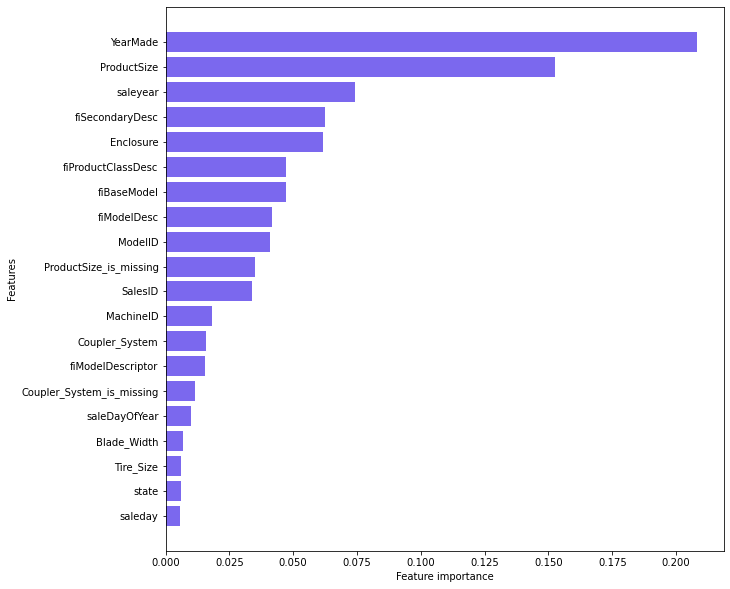

In [116]:
plot_features(X_train.columns, 
              ideal_model.feature_importances_)

Knowing the feature importances of trained machine learning models is beneficial because:

* You can better understand the model's logic so you can verify its correctness in prediction.
* You can hone in on the most important variables and discard variables that are not significant in the model's decision-making process, thereby giving similar or even better performance of the model and in a shorter training time.

(Source: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

Other regression machine learning models I could try on this data according to [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)?
* CatBoost.ai
* XGBoost.ai